In [1]:
import polars as pl
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import torch

import utils_funcs as futil

In [2]:
torch.set_default_dtype(torch.float64)
torch.set_printoptions(precision=3)  # show 3 decimal places

In [3]:
figsize1 = (4,3)
figsize2 = (4,5)
figsize3 = (4,8)
figsizeH = (9.5,5)

In [4]:
batch = 'Batch3'
name = '1Day'
condition = 'Suc' 
replicate = 'R2'

core = batch + '_' + name
col1 = core + '-T0_combined'

core = core + '_' + condition + '-' + replicate
col2 = core + '-T1_combined'
col3 = core + '-T2_combined'
col4 = core + '-T3_combined'
col5 = core + '-T4_combined'

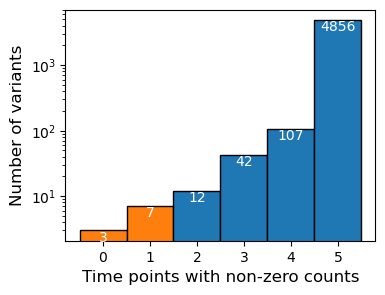

Dropped  : 10
Remaining: 5017


In [5]:
# Read the CSV file
selected = pl.read_csv("data/" + core + "_time.csv")

# Select the columns you want (replace col1, col2 with your column names)
cols_sel = [col1, col2, col3, col4, col5]

# Count rows before filtering
n_before = selected.height

#############################

# Count non-zeros per row
oks = torch.tensor(selected.to_numpy())
nonzero_counts = torch.count_nonzero(oks, dim=1)

values, counts = np.unique(nonzero_counts, return_counts=True)

plt.figure(figsize=(4, 3)) 

# Build color list: first 2 orange, rest blue
clrs = ['C1'] * 2 + ['C0'] * (len(values) - 2)

plt.bar(values, counts, width=1, align="center", edgecolor="black",color=clrs)

# Add numbers above bars
for x, y in zip(values, counts):
    plt.text(x, y, str(y), ha='center', va='top', color='white', fontsize=10)

# Force integer ticks
plt.xticks(torch.arange(nonzero_counts.min(), nonzero_counts.max() + 1, 1))
plt.yscale('log')

plt.xlabel("Time points with non-zero counts",fontsize=12)
plt.ylabel("Number of variants",fontsize=12)


plt.savefig(f'data/figs/data_hist.pdf', bbox_inches='tight')
plt.show()

####################################

# Filter rows: keep only if at least 2 counts are > 0
filtered = selected.filter(
    (pl.sum_horizontal([pl.col(c) > 0 for c in cols_sel]) >= 2)
)

# Count rows after filtering
n_after = filtered.height
n_dropped = n_before - n_after
print("Dropped  :",n_dropped)
print("Remaining:",n_after)

# Convert to Pytorch
reads = torch.tensor(filtered.select(cols_sel).to_numpy())
reads_tot = reads.sum(axis=0)

In [6]:
#stop

tensor([5, 5, 5,  ..., 5, 5, 5])


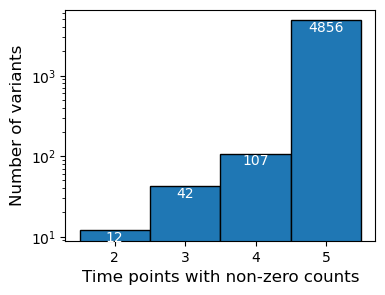

tensor(True)


In [7]:
# Count non-zeros per row
nonzero_counts = torch.count_nonzero(reads, dim=1)

print(nonzero_counts)  
# tensor([2, 1, 2])

# Plot histogram
# Convert to NumPy for matplotlib
oks = nonzero_counts

values, counts = np.unique(oks, return_counts=True)

plt.figure(figsize=(4, 3)) 

plt.bar(values, counts, width=1, align="center", edgecolor="black")

# Add numbers above bars
for x, y in zip(values, counts):
    plt.text(x, y, str(y), ha='center', va='top', color='white', fontsize=10)

# Force integer ticks
plt.xticks(torch.arange(oks.min(), oks.max() + 1, 1))
plt.yscale('log')

plt.xlabel("Time points with non-zero counts",fontsize=12)
plt.ylabel("Number of variants",fontsize=12)
plt.show()

# Check condition
ok = (nonzero_counts >= 2).all()
print(ok)  

if not ok:
    stop

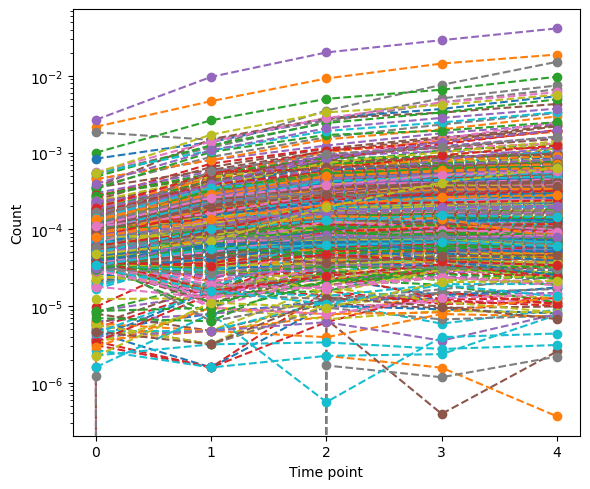

In [8]:
start = 0
end = start + 1000

# ---- PLOTTING
N,T = reads.shape
time_index = range(T)

# Plot each column as a line
plt.figure(figsize=(6, 5))
for row in reads[start:end]:
    plt.plot(time_index, row/reads_tot,'--o')

plt.xticks(time_index)
plt.yscale('log')


plt.xlabel("Time point")
plt.ylabel("Count")
#plt.legend()
plt.tight_layout()
plt.show()

# ANALYSIS

In [9]:
model = 'exponential'
#model = 'logistic'

# Initial cell density as fraction of carrying capacity
K_N0 = torch.log(torch.tensor(1e3)) 

# number of variants
K = n_after
reads = reads[:K]
# Experimental time points
if name == '1Day':
    mult = 24
elif name == '2Day':
    mult = 48

times = mult * torch.tensor([0, 1, 2, 3, 4], dtype=torch.float32)
T = len(times)

In [10]:
# ---- Plotting ----
#if K < 11:
#    colors = plt.cm.tab10(np.linspace(0, 1, K))
#else:
colors = plt.cm.tab20(np.linspace(0, 1, K))

# Define a list of markers
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'P', '*', 'X']

### Integrate time dynamics

In [11]:
# Fine-grained time to integrate the dynamics
pntN = int(times[-1])*5+1
times_fine = torch.linspace(times[0], times[-1], steps=pntN)

# Find the matching indices between the fine-grained and experimental time points
selected_indices = torch.tensor([
    torch.argmin(torch.abs(times_fine - t)).item()
    for t in times
])

# output
print("Selected indices:", selected_indices)
print(times_fine[selected_indices])
print(times)

params_time = [times_fine,selected_indices]

Selected indices: tensor([  0, 120, 240, 360, 480])
tensor([ 0., 24., 48., 72., 96.])
tensor([ 0., 24., 48., 72., 96.], dtype=torch.float32)


# Maximum Likelihood

In [12]:
lr = 0.003
tol_loss = 1e-4
tol_vals = 1e-4
num_iterations=20000

growth_rates_ML, log_abundances_ML, history_ML = futil.optimize_LogLike(reads, params_time, model, K_N0,  
                                         lr=lr,tol=(tol_loss,tol_vals), num_iterations=num_iterations)
params_ML = [growth_rates_ML,log_abundances_ML]

Initial Params : lams = [0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100

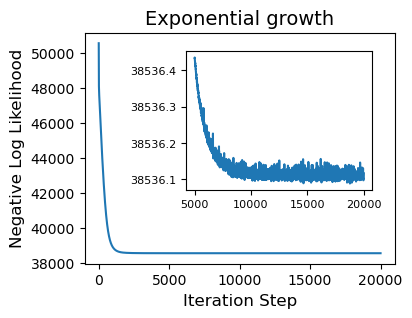

In [13]:
inset_start = 5000

fig = futil.plot_History(history_ML,model,inset_start,figsize=figsize1)
save_fig = True
if save_fig:
    plt.savefig(f'data/figs/ML_K{K}_{model}_history.pdf', bbox_inches='tight')

In [14]:
print(growth_rates_ML)
print("\n")
print(log_abundances_ML)

tensor([ 0.004,  0.018,  0.015,  ...,  0.006,  0.007, -0.026])


tensor([ -8.947,  -6.137,  -9.387,  ..., -10.613,  -9.728, -11.738])


In [15]:
# This plot takes a long time

make_fig = False

if make_fig:
    fracs_empir = reads/reads.sum(dim=0)

    # ---- Calculate fractions ----
    ys_ML = futil.dynamics(model,K_N0,times_fine,growth_rates_ML,log_abundances_ML)
    fracs_ML =torch.softmax(ys_ML,dim=0)

    rows = 25
    cols = 10
    K_split = int(K/rows/cols)
    colors = plt.cm.tab20(np.linspace(0, 1, K_split))[::-1]

    # ---- Plotting ----
    fig, axes = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(2*cols, 2*rows))
    plt.subplots_adjust(wspace=0, hspace=0)

    for row in range(rows):
        for col in range(cols):
            # Create the subplot
            ax = axes[row, col]

            start = (row*cols + col)*K_split
            end = (row*cols + col+1)*K_split

            for k in range(start,end):
                color = colors[(k-start) % len(colors)]
                marker=markers[(k-start) % len(markers)]

                if k == start:
                    ax.plot(times_fine,fracs_ML[k],'-', color=color,label='ML Time')
                    ax.plot(times,fracs_empir[k],' ',marker=marker,color=color,label='Emp')
                else:
                    ax.plot(times_fine,fracs_ML[k], '-', color=color) #Maxlike
                    ax.plot(times, fracs_empir[k], ' ',color=color,marker=marker)

            #ax1.set_xlabel('Time', fontsize=12)
            ax.set_xticks(times)
            ax.set_ylim(2e-8,3e-1)
            ax.set_yscale('log')
            if col == cols:
                ax.set_ylabel('Variant Fraction', fontsize=10)
            ax.set_title(f"{start} - {end}")

            if row == rows-1:
                ax.set_xlabel('Time  [h]', fontsize=12)
            else:
                # Turn off x-axis labels for ax1 to avoid redundancy
                plt.setp(ax.get_xticklabels(), visible=False)

    plt.tight_layout()

    save_fig = True
    if save_fig:
        plt.savefig(f'data/figs/ML_K{K}_{model}_traces.pdf', bbox_inches='tight')
    plt.show()

In [16]:
#stop

# Variational Bayes

In [17]:
num_steps = int(500)
lr = 0.03
M =  600  # Monte Carlo samples
F = 100  # Final averaging window

growth_rates_VB,sigmasL_VB,log_abundances_VB,sigmasD_VB,history_VB \
    = futil.optimize_ELBO(reads, params_time, model,K_N0, num_steps,lr,M,F, params_ML)

params_VB = [growth_rates_VB,log_abundances_VB]
sigmas_VB = [sigmasL_VB,sigmasD_VB]

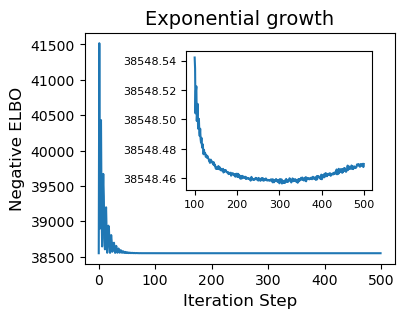

In [18]:
inset_start = 100
fig = futil.plot_History(history_VB,model,inset_start,figsize=figsize1,ylabel='Negative ELBO')

save_fig = True
if save_fig:
    plt.savefig(f'data/figs/VB_K{K}_{model}_history.pdf', bbox_inches='tight')

In [19]:
print(growth_rates_VB)
print(sigmasL_VB,"\n")
print(log_abundances_VB)
print(sigmasD_VB)

tensor([ 0.004,  0.018,  0.016,  ...,  0.006,  0.007, -0.026])
tensor([2.273e-04, 3.227e-05, 1.696e-04,  ..., 4.767e-04, 2.955e-04,
        3.110e-03]) 

tensor([ -8.945,  -6.143,  -9.384,  ..., -10.609,  -9.724, -11.740])
tensor([0.013, 0.002, 0.012,  ..., 0.030, 0.019, 0.075])


In [20]:
# sort growth rates for plotting
growth_rates_VB, indices = torch.sort(growth_rates_VB, descending=True)

# Reorder the others using the same indices
sigmasL_VB = sigmasL_VB[indices]

muD_avg = log_abundances_VB[indices]
sigD_avg = sigmasD_VB[indices]

# and Max Like arrays

growth_rates_ML = growth_rates_ML[indices]
log_abundances_ML = log_abundances_ML[indices]

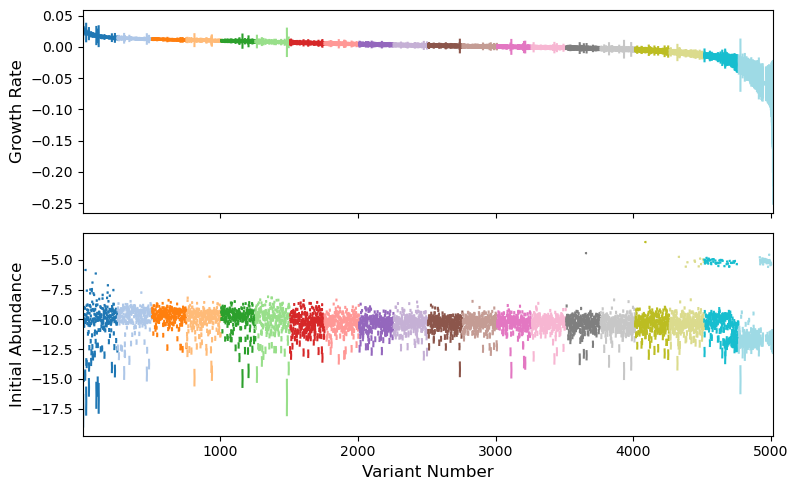

In [21]:
fig = plt.figure(figsize=(8, 5))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

# Create the first subplot 
ax1 = plt.subplot(gs[0])

for b in range(K):
    color = colors[b % len(colors)]
    
    mu = growth_rates_VB[b]
    sig = sigmasL_VB[b]

    yy = torch.linspace(mu-3*sig,mu+3*sig,100)
    xx = torch.exp(-0.5*((yy-mu)/sig)**2)

    if b==K-1:        
        ax1.plot(0.8*xx + (b+1) - 0.3, yy, '-', color=color,label='VarBayes')
        #ax1.plot([b+0.7,b+1.5],[growth_rates_ML[b],growth_rates_ML[b]],'--', color=color,label='MaxLike') 
    else:
        ax1.plot(0.8*xx + (b+1) - 0.3, yy,'-', color=color)
        #ax1.plot([b+0.7,b+1.5],[growth_rates_ML[b],growth_rates_ML[b]],'--', color=color)
        
ax1.set_xlim(0.1,K+0.9)
#ax1.set_xticks(range(1,K+1))
ax1.set_ylabel("Growth Rate",fontsize=12)

# Create the second subplot 
ax2 = plt.subplot(gs[1], sharex=ax1)
# Turn off x-axis labels for ax1 to avoid redundancy
plt.setp(ax1.get_xticklabels(), visible=False)

for b in range(K):
    color = colors[b % len(colors)]
    
    mu = muD_avg[b]
    sig = sigD_avg[b]

    yy = torch.linspace(mu-3*sig,mu+3*sig,100)
    xx = torch.exp(-0.5*((yy-mu)/sig)**2)

    if b==K-1:        
        ax2.plot(0.8*xx + (b+1) - 0.3, yy, '-', color=color,label='VarBayes')
        put_labels = False
    else:
        ax2.plot(0.8*xx + (b+1) - 0.3, yy,'-', color=color)        
            
ax2.set_xlim(0.1,K+0.9)
#ax2.set_xticks(range(1,K+1,2))
ax2.set_ylabel("Initial Abundance",fontsize=12)
ax2.set_xlabel("Variant Number",fontsize=12)
#ax2.legend(loc='upper right',frameon=False)

plt.tight_layout()

save_fig = True
if save_fig:
    plt.savefig(f'data/figs/VB_K{K}_{model}_gauss1.pdf', bbox_inches='tight')

plt.show()

In [22]:
# sort initial abundances for plotting
muD_avg, indices = torch.sort(log_abundances_VB, descending=True)

# Reorder the others using the same indices
growth_rates_VB = growth_rates_VB[indices]
sigmasL_VB = sigmasL_VB[indices]
#muD_avg = muD_avg[indices]
sigD_avg = sigmasD_VB[indices]

# and Max Like arrays

growth_rates_ML = growth_rates_ML[indices]
log_abundances_ML = log_abundances_ML[indices]

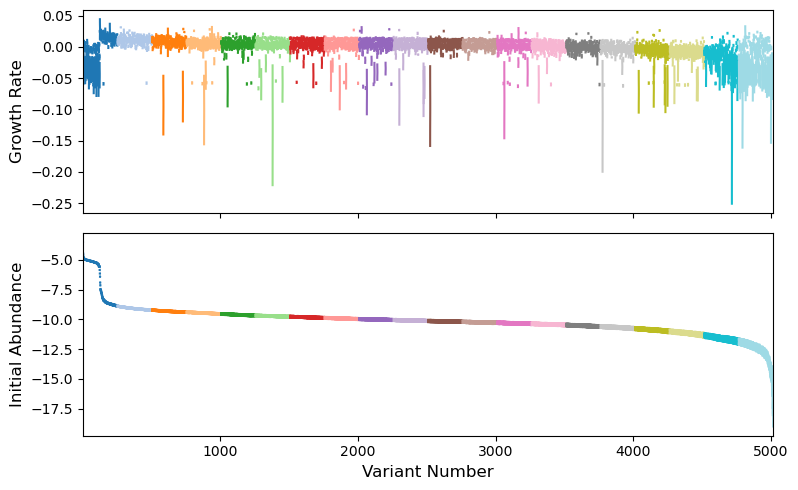

In [23]:
fig = plt.figure(figsize=(8, 5))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

# Create the first subplot 
ax1 = plt.subplot(gs[0])


for b in range(K):
    color = colors[b % len(colors)]
    
    mu = growth_rates_VB[b]
    sig = sigmasL_VB[b]

    yy = torch.linspace(mu-3*sig,mu+3*sig,100)
    xx = torch.exp(-0.5*((yy-mu)/sig)**2)

    if b==K-1:        
        ax1.plot(0.8*xx + (b+1) - 0.3, yy, '-', color=color,label='VarBayes')
    else:
        ax1.plot(0.8*xx + (b+1) - 0.3, yy,'-', color=color)
            
ax1.set_xlim(0.1,K+0.9)
#ax1.set_xticks(range(1,K+1))
ax1.set_ylabel("Growth Rate",fontsize=12)

# Create the second subplot 
ax2 = plt.subplot(gs[1], sharex=ax1)
# Turn off x-axis labels for ax1 to avoid redundancy
plt.setp(ax1.get_xticklabels(), visible=False)

for b in range(K):
    color = colors[b % len(colors)]
    
    mu = muD_avg[b]
    sig = sigD_avg[b]

    yy = torch.linspace(mu-3*sig,mu+3*sig,100)
    xx = torch.exp(-0.5*((yy-mu)/sig)**2)

    if b==K-1:        
        ax2.plot(0.8*xx + (b+1) - 0.3, yy, '-', color=color,label='VarBayes')
        #ax2.plot([b+0.7,b+1.5],[log_abundances_ML[b],log_abundances_ML[b]],'--', color=color,label='MaxLike')
        put_labels = False
    else:
        ax2.plot(0.8*xx + (b+1) - 0.3, yy,'-', color=color)
        #ax2.plot([b+0.7,b+1.5],[log_abundances_ML[b],log_abundances_ML[b]],'--', color=color)
        
            
ax2.set_xlim(0.1,K+0.9)
#ax2.set_xticks(range(1,K+1,2))
ax2.set_ylabel("Initial Abundance",fontsize=12)
ax2.set_xlabel("Variant Number",fontsize=12)
#ax2.legend(loc='upper right',frameon=False)

plt.tight_layout()

save_fig = True
if save_fig:
    plt.savefig(f'data/figs/VB_K{K}_{model}_gauss2.pdf', bbox_inches='tight')

plt.show()

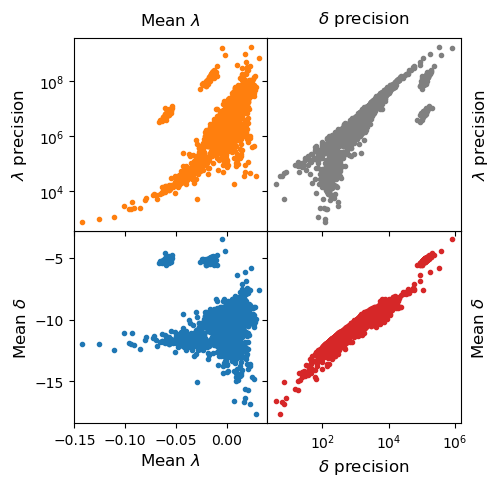

In [24]:
# offsets in figure coordinates
x_off = 0.02
y_off = 0.02

fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(2, 2, wspace=0.0, hspace=0.0)

# Bottom-left
ax1 = plt.subplot(gs[1, 0])
ax1.plot(params_VB[0], params_VB[1], '.', color='C0')
#ax1.set_yscale("log")
ax1.set_xlabel(r'Mean $\lambda$',fontsize=12)
ax1.set_ylabel(r'Mean $\delta$',fontsize=12)

# Top-left
ax = plt.subplot(gs[0, 0])
ax.plot(params_VB[0], 1/sigmas_VB[0]**2, '.', color='C1')
ax.set_yscale("log")
ax.set_xlabel('')
ax.set_ylabel(r'$\lambda$ precision',fontsize=12)
# hide bottom tick labels (since this is the top row)
ax.tick_params(labelbottom=False)

# add top x-label
top_ax = ax
bbox = top_ax.get_position()
x_center = 0.5 * (bbox.x0 + bbox.x1)
y = bbox.y1 + y_off
fig.text(x_center, y, r'Mean $\lambda$', ha="center", va="bottom",fontsize=12)

fig.align_ylabels([ax1, ax])

# Bottom-right
ax = plt.subplot(gs[1, 1])
ax.plot(1/sigmas_VB[1]**2, params_VB[1], '.', color='C3')
ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_xlabel(r'$\delta$ precision',fontsize=12)
ax.set_ylabel('')
# hide left tick labels (since this is the right column)
ax.tick_params(labelleft=False)

# add right y-label
right_ax = ax
bbox = right_ax.get_position()
x = bbox.x1 + x_off
row_bbox = ax1.get_position()
y_center = 0.5 * (row_bbox.y0 + row_bbox.y1)
fig.text(x, y_center, r'Mean $\delta$', rotation=90, va="center", ha="left",fontsize=12)

# Top-right
ax = plt.subplot(gs[0, 1])
ax.plot(1/sigmas_VB[1]**2, 1/sigmas_VB[0]**2, '.', color='gray')
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(labelleft=False, labelbottom=False)  # inner ticks off

# add top x-label
bbox = ax.get_position()
x_center = 0.5 * (bbox.x0 + bbox.x1)
y = bbox.y1 + y_off
fig.text(x_center, y, r'$\delta$ precision', ha="center", va="bottom",fontsize=12)

# add right y-label
bbox = ax.get_position()
x = bbox.x1 + x_off
row_bbox = axes_pos = ax.get_position()
y_center = 0.5 * (row_bbox.y0 + row_bbox.y1)
fig.text(x, y_center, r'$\lambda$ precision', rotation=90,
         va="center", ha="left",fontsize=12)

save_fig = True
if save_fig:
    plt.savefig(f'data/figs/VB_K{K}_{model}_cross.pdf', bbox_inches='tight')

plt.show()